In [128]:
import sys
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn import cluster, datasets
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import pairwise

from random import randint

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AffinityPropagation
from sklearn import metrics

#hiding warning messages
import warnings
warnings.filterwarnings("ignore")

#Reading in Summary MERGED CSV
data = pd.read_csv('Molecular_Properties_CSV')
data = data.astype(float, errors = 'ignore')
data = data.dropna()
data.head()

,Activity Summary,PUBCHEM_CID,Ratio Efficacy (%),Ratio Potency (uM),MolecularFormula,MolecularWeight,CanonicalSMILES,IsomericSMILES,InChI,XLogP,ExactMass,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,Complexity
0,inactive,997.0,0.0000,0.00000,C9H8O3,164.160,C1=CC=C(C=C1)CC(=O)C(=O)O,C1=CC=C(C=C1)CC(=O)C(=O)O,InChI=1S/C9H8O3/c10-8(9(11)12)6-7-4-2-1-3-5-7/...,1.3,164.047344,54.4,1.0,3.0,3.0,12.0,180.0
1,active antagonist,1807.0,-116.2980,54.94100,C4H6BrNO4,211.999,C1C(COCO1)([N+](=O)[O-])Br,C1C(COCO1)([N+](=O)[O-])Br,InChI=1S/C4H6BrNO4/c5-4(6(7)8)1-9-3-10-2-4/h1-3H2,0.3,210.948020,64.3,0.0,4.0,0.0,10.0,139.0
2,active antagonist,2453.0,-141.2610,10.68220,C9H5Br2NO,302.953,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,C1=CC2=C(C(=C(C=C2Br)Br)O)N=C1,InChI=1S/C9H5Br2NO/c10-6-4-7(11)9(13)8-5(6)2-1...,3.2,302.871740,33.1,1.0,2.0,0.0,13.0,191.0
3,active antagonist,2662.0,-42.8802,21.31380,C17H14F3N3O2S,381.373,CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)...,CC1=CC=C(C=C1)C2=CC(=NN2C3=CC=C(C=C3)S(=O)(=O)...,InChI=1S/C17H14F3N3O2S/c1-11-2-4-12(5-3-11)15-...,3.4,381.075882,86.4,1.0,7.0,3.0,26.0,577.0
4,active antagonist,2722.0,-116.0110,5.56323,C9H5Cl2NO,214.045,C1=CC2=C(C(=C(C=C2Cl)Cl)O)N=C1,C1=CC2=C(C(=C(C=C2Cl)Cl)O)N=C1,InChI=1S/C9H5Cl2NO/c10-6-4-7(11)9(13)8-5(6)2-1...,3.5,212.974819,33.1,1.0,2.0,0.0,13.0,191.0


In [94]:
#Making a 'target column', where inactives are 0 and actives are 1
activity_list = data['Activity Summary']
activity_list = activity_list.tolist()
target_list = []
i = 0

while (i < len(activity_list)):
    if (activity_list[i] == 'active antagonist'):
        target_list.append('1')
        i = i + 1
    elif (activity_list[i] == 'active agonist'):
        target_list.append('1')
        i = i + 1
    else:
        target_list.append('0')
        i = i + 1
        
#Making strings ints
target_list = [int(i) for i in target_list]

#adding target column to data
data['target'] = target_list

In [95]:
##ALSO drop pubchem_CID because thats not a feature
data_numerical = data.drop(['PUBCHEM_CID', 'Ratio Potency (uM)', 'Ratio Efficacy (%)', 'ExactMass', 'CanonicalSMILES', 'IsomericSMILES', 'InChI', 'MolecularFormula', 'target'], axis = 1)

In [97]:
#Taking Dataframe of only Inactive values
###Drop all active agonists and active antagonists
df_inactive = data_numerical.drop(data_numerical.loc[data['Activity Summary'] == 'active agonist'].index)
df_inactive = df_inactive.drop(df_inactive.loc[df_inactive['Activity Summary'] == 'active antagonist'].index)
df_inactive = df_inactive.drop(['Activity Summary'], axis = 1)

#Taking Dataframe of only Active values
##Dropping all inactive values
df_active = data_numerical.drop(data.loc[data['Activity Summary'] == 'inactive'].index)
df_active = df_active.drop(['Activity Summary'], axis = 1)

In [98]:
#Printing number of active compounds
print("Number of active compounds in data: ")
print(len(df_active.index))

Number of active compounds in data: 
605


In [99]:
df_inactive.head()

,MolecularWeight,XLogP,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,Complexity
0,164.160,1.3,54.4,1.0,3.0,3.0,12.0,180.0
5,318.863,5.2,31.8,0.0,3.0,4.0,21.0,339.0
8,258.310,2.0,119.0,1.0,6.0,3.0,16.0,341.0
10,373.300,4.3,0.0,0.0,0.0,0.0,17.0,467.0
12,416.123,5.3,27.0,0.0,2.0,6.0,25.0,407.0


# PCA

In [67]:
from sklearn import preprocessing
df_numerical_arr = np.array(df_numerical)
df_normalized = preprocessing.normalize(df_numerical_arr, axis = 0)
from sklearn import decomposition

In [68]:
pca = decomposition.PCA()
df_transformed = pca.fit_transform(df_normalized)
pca.components_

array([[ 0.29490949, -0.10688934,  0.4311706 ,  0.46165188,  0.41472929,
         0.26893109,  0.3000101 ,  0.41017331],
       [ 0.21895672,  0.72644412, -0.15689501, -0.34036766, -0.07018943,
         0.43200453,  0.22794062,  0.20089625],
       [-0.17478524, -0.19735098,  0.00302591,  0.18590327, -0.14381877,
         0.82384192, -0.16731415, -0.41053643],
       [-0.07423949, -0.24781215,  0.03050093, -0.64222892,  0.69967526,
         0.14259478, -0.06963231, -0.0704411 ],
       [-0.14841458,  0.51098851, -0.17374125,  0.43333458,  0.54258422,
        -0.14231925, -0.1770199 , -0.39103775],
       [-0.18686584,  0.30761455,  0.86116816, -0.1716936 , -0.12925022,
        -0.07347908, -0.23693896, -0.14532822],
       [ 0.8221646 , -0.06548367,  0.08995621, -0.07027532, -0.03650974,
        -0.09720589,  0.02774284, -0.54330002],
       [-0.3100397 , -0.02170857,  0.0929928 , -0.04258182, -0.0201876 ,
        -0.08304486,  0.85845708, -0.38560435]])

In [69]:
pca.explained_variance_

array([3.65453055e-04, 1.43290453e-04, 3.99187895e-05, 2.47782628e-05,
       1.68376328e-05, 7.16769182e-06, 2.64268042e-06, 8.60878224e-07])

In [70]:
pca.explained_variance_ratio_

array([0.60812612, 0.23844011, 0.0664262 , 0.04123186, 0.02801838,
       0.01192728, 0.00439751, 0.00143253])

In [72]:
print( "#-- Sample 1 before/after normalization : ", "\n" )
print( " (Original            ) ", df_numerical_arr[0] )
print( " (After normalization ) ", df_normalized[0] )
print( " (After transformation) ", df_transformed[0] )

#-- Sample 1 before/after normalization :  

 (Original            )  [164.16   1.3   54.4    1.     3.     3.    12.   180.  ]
 (After normalization )  [0.00676239 0.00479945 0.00778559 0.00537634 0.00807801 0.00591893
 0.00728103 0.00516374]
 (After transformation)  [-5.53598520e-03 -5.40525899e-03  9.86788732e-04  1.78147852e-03
  4.59462853e-04  5.64266787e-04 -7.73215855e-04  3.16937450e-05]


In [78]:
pd.DataFrame(df_transformed).head

<bound method NDFrame.head of              0         1         2         3         4         5         6  \
0    -0.005536 -0.005405  0.000987  0.001781  0.000459  0.000564 -0.000773   
1    -0.005032  0.011801 -0.005139  0.000674  0.002072 -0.000162  0.001092   
2     0.005291 -0.003215 -0.003637  0.006293  0.001745  0.006306  0.000341   
3    -0.010673  0.007934 -0.011330 -0.005675 -0.003434 -0.003857  0.001743   
4    -0.002714  0.015893 -0.003483 -0.001363 -0.001430 -0.002189  0.003022   
5    -0.001521  0.005242 -0.003268 -0.005886  0.007712  0.001405 -0.001168   
6    -0.008806 -0.000102  0.002322 -0.001159  0.002265 -0.001921 -0.000424   
7    -0.002596  0.015950 -0.003601 -0.001384 -0.001542 -0.002230  0.002866   
8     0.003061 -0.007569 -0.002329 -0.000414  0.000935  0.001883  0.000684   
9     0.010323 -0.015574 -0.001485  0.001850  0.000606 -0.001720 -0.000800   
10   -0.008172 -0.004933 -0.004401 -0.000092  0.003986  0.002280  0.000004   
11   -0.006042  0.005699 -0.004646

In [181]:
#normalizing data 
df_inactive_pca = StandardScaler().fit_transform(df_inactive)

#computing covariance matrix
cov_mat = np.cov(df_inactive_pca.T)

#computing eigenvalues and eigenvectors using numpy
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

#Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]

#Sort the eigehvalue, eigenvector) tuples from high to low
eig_pairs.sort(key = lambda x: x[0], reverse = True)

In [182]:
#Calculating "explained variance percentage"
##Quantifies how much info/variance can be attributed to each of the principal components
#only keeping a certain number of eigenvalues based on prespecified threshold

exp_var_percentage = 0.97 # Threshold of 97% explained variance

tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

num_vec_to_keep = 0

for index, percentage in enumerate(cum_var_exp):
    if percentage > exp_var_percentage:
        num_vec_to_keep = index + 1
        break

In [183]:
#Project our data on the vectors we want to keep
#Build a projection nmatrix (matrix we will multiply by to project our data onto the new vectors)

num_features = df_inactive.shape[1]
proj_mat = eig_pairs[0][1].reshape(num_features, 1)
for eig_vec_idx in range(1, num_vec_to_keep):
    proj_mat = np.hstack((proj_mat, eig_pairs[eig_vec_idx][1].reshape(num_features,1)))

# Project the data 
pca_data = df_inactive_pca.dot(proj_mat)

In [184]:
print(pca_data)

[[ 8.32348917e-01]
 [ 1.95648861e-01]
 [-5.23106578e-01]
 ...
 [-9.59677694e-01]
 [-4.14606403e-03]
 [-8.57345478e+00]]


In [10]:
#Undersampling: Cluster Centroids

In [197]:
#standardizing
#df_std = stats.zscore(pca_data)

#Cluster the data
km = KMeans(n_clusters=605, random_state=0)
km.fit_predict(df_inactive)
km.predict(df_active)
cls_id = km.labels_
ctr_crd = km.cluster_centers_
n_clusters_ = len(ctr_crd)

In [198]:
metrics.silhouette_score(df_inactive, cls_id, metric='euclidean')

0.25168956012089855

In [199]:
df_inactive_arr = np.array(df_inactive)
df_active_arr = np.array(df_active)

In [203]:
len(X_dist_inact)

6368

In [201]:
members = []
num_actives = []
num_inactives = []
dist_to_center = []
X_dist_act = []
X_dist_inact = []

for i in range( len( ctr_crd ) ) :    #-- Initialize the arrays.

    members.append( [] )
    num_actives.append( 0 )
    num_inactives.append( 0 )
    dist_to_center.append( [] )

for i in range( len( df_inactive ) ) :

    members[ cls_id[i] ].append( i )

    dist_to_center_tmp = pairwise.euclidean_distances( df_inactive_arr[i].reshape(1,-1), ctr_crd[ cls_id[i] ].reshape(1, -1))
    dist_to_center[cls_id[i]].append( dist_to_center_tmp )

    X_dist_inact.append( dist_to_center_tmp[0][0] )
    
for i in range( len( df_active ) ) :

    dist_to_center_tmp = pairwise.euclidean_distances( df_active_arr[i].reshape(1,-1), ctr_crd[ cls_id[i] ].reshape(1, -1))

    X_dist_act.append( dist_to_center_tmp[0][0] )

#for i in range( len( ctr_crd ) ) :

#    for j in range( len( ctr_crd[ i ] ) ) :
#        print( "\t%14.6e" % ctr_crd[i][j], end='')

pd.DataFrame(ctr_crd)

,0,1,2,3,4,5,6,7
0,158.437167,-0.750000,101.083333,2.333333,3.833333,1.000000,11.000000,272.000000
1,521.030000,-0.750000,244.750000,3.750000,10.250000,8.500000,35.000000,950.750000
2,1203.499000,-2.500000,491.000000,18.000000,18.000000,29.000000,85.000000,2150.000000
3,448.103500,5.633333,25.383333,0.500000,10.166667,6.333333,28.666667,562.833333
4,115.432000,0.605556,42.255556,1.166667,2.138889,1.500000,7.666667,67.858333
5,294.947667,2.842857,63.623810,1.380952,3.523810,7.190476,20.142857,298.285714
6,869.147000,3.600000,186.000000,4.000000,15.000000,12.000000,61.000000,1420.000000
7,1877.658000,-0.200000,662.000000,24.000000,34.000000,19.000000,132.000000,3980.000000
8,160.313310,1.982759,29.737931,0.482759,1.793103,1.965517,11.655172,169.896552
9,421.543538,4.169231,68.238462,0.846154,5.000000,5.538462,29.923077,644.000000


In [151]:
#standardizing
clmns = ['MolecularWeight','XLogP','TPSA','HBondDonorCount','HBondAcceptorCount','RotatableBondCount','HeavyAtomCount','Complexity']
df_std = stats.zscore(df_transformed)

#Cluster the data
kmeans = KMeans(n_clusters=605, random_state=0).fit(df_std)
labels = kmeans.labels_


#Glue back to originaal data
df_numerical['clusters'] = labels

#Add the column into our list
clmns.extend(['clusters'])

#Lets analyze the clusters
#print(df_numerical[clmns].groupby(['clusters']).mean())

df_numerical = df_numerical.sort_values(by = ['clusters'], ascending = True, inplace = False)
df_numerical.head(20)

,MolecularWeight,XLogP,TPSA,HBondDonorCount,HBondAcceptorCount,RotatableBondCount,HeavyAtomCount,Complexity,clusters
5893,285.235,-0.6,140.0,4.0,9.0,2.0,20.0,367.0,0
3601,224.193,0.5,61.8,0.0,5.0,8.0,14.0,206.0,0
3219,164.204,2.6,37.3,1.0,2.0,1.0,12.0,165.0,0
3966,450.480,3.7,170.0,3.0,9.0,4.0,30.0,849.0,0
4866,130.190,3.5,0.0,0.0,0.0,2.0,10.0,100.0,0
4369,175.275,2.4,26.0,1.0,1.0,1.0,13.0,153.0,0
730,154.253,3.7,17.1,0.0,1.0,7.0,11.0,105.0,0
793,436.363,5.4,71.9,1.0,10.0,9.0,31.0,572.0,0
911,577.722,3.1,119.0,3.0,7.0,10.0,42.0,915.0,0
2802,154.169,0.1,58.2,2.0,2.0,4.0,11.0,167.0,0


In [155]:
metrics.silhouette_score(df_numerical, cls_id, metric='euclidean')

-0.786600724601683

Text(28.559609375000008, 0.5, 'TPSA')

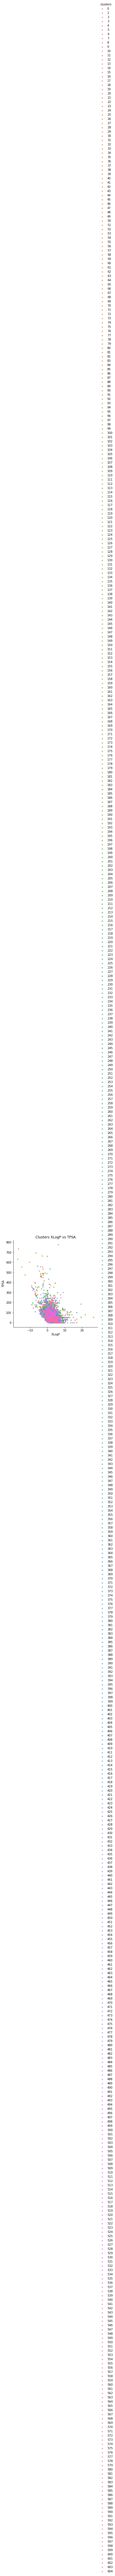

In [12]:
sns.lmplot('XLogP', 'TPSA', 
           data=df_numerical, 
           fit_reg=False, 
           hue="clusters",  
           scatter_kws={"marker": "D", 
                        "s": 10})
plt.title('Clusters XLogP vs TPSA')
plt.xlabel('XLogP')
plt.ylabel('TPSA')

In [13]:
print(df_numerical[clmns].groupby(['clusters']).mean())

            ExactMass        TPSA      XLogP
clusters                                    
0          349.063500  136.500000   2.000000
1          163.010071   26.932143   2.135714
2          867.101500  361.500000   1.500000
3          290.553125   36.462500   5.337500
4          220.418625   78.431250  -1.243750
5          551.275667  135.333333   4.833333
6          449.865750   37.925000  10.900000
7         1447.430000  531.000000  -2.600000
8          276.061826   54.052174   2.421739
9          457.986714  202.285714  -0.985714
10         137.096625   62.793750   0.156250
11         218.719269   16.788462   3.711538
12         387.967556   53.272222   4.005556
13         613.920000  356.000000  -8.933333
14         275.009273   78.609091   0.645455
15         692.116000  236.500000   2.675000
16         520.817800   78.940000   7.280000
17         105.212417   40.941667  -0.091667
18         712.579000   35.500000  16.900000
19         179.728000  126.333333  -4.333333
20        

In [ ]:
#also PCA and Undersampling

In [14]:
#df_numerical_no_targets = df_numerical.drop(columns = ['target'], axis = 1)
clmns2 = ['ExactMass', 'TPSA', 'XLogP']
X = np.array(data[clmns2])
y = np.array(data['target'])

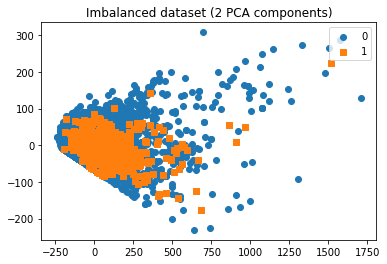

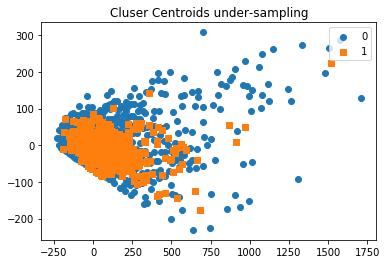

In [15]:
def plot_2d_space(X, y, label='Classes'):   
    colors = ['#1F77B4', '#FF7F0E']
    markers = ['o', 's']
    for l, c, m in zip(np.unique(y), colors, markers):
        plt.scatter(
            X[y==l, 0],
            X[y==l, 1],
            c=c, label=l, marker=m
        )
    plt.title(label)
    plt.legend(loc='upper right')
    plt.show()

    
    
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X = pca.fit_transform(X)

plot_2d_space(X, y, 'Imbalanced dataset (2 PCA components)')
    
    
    
    

cc = ClusterCentroids(ratio={0: 605})
X_cc, y_cc = cc.fit_sample(X, y)

plot_2d_space(X_cc, y_cc, 'Cluser Centroids under-sampling')

In [ ]:
len(y_cc)

In [ ]:
from math import sqrt
def CCMUT(X,f):
    # 1. finding cluster centroid....
    cluster_centroid = np.sum(X,axis=0)/X.shape[0]
    # 2. finding Euclidean Distance from cluster centroid to samples
    euclidean = [None]*X.shape[0]
    for i in range(0,X.shape[0]):
        euclidean[i] = sqrt(sum((cluster_centroid-X[i])**2))
    # 3. tracking indices of samples in descending order of distance
    indices = list(reversed(sorted(range(len(euclidean)), 
    key = lambda j: euclidean[j])))
    # 4. removing the instances or under-sampling order-wise....
    X_f = np.delete(X, indices[:int(f/100*X.shape[0])], axis=0)
    # 5. returning the under-sampled Majority Sample Matrix
    return X_f

CCMUT(df_numerical, .5)